## Import modules

In [1]:
import math
import random
import time
import string
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from pylab import rcParams
from scipy.io import loadmat
import category_encoders as ce

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import KFold
from pandas.api.types import is_string_dtype, is_numeric_dtype

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# CatBoost - 2 (Target Statistics 실험)

## Target Statistic별 설명

- 다음부터는 Target Statistic (TS)를 계산하는 알고리즘들에 대해 각각 설명을 하고, 이를 통하여 구현하는 과정입니다.
    - Conventional categorical encoding
        - One-hot encoding
        - Label encoding
    - Target / Mean encoding (TS)
        - Conventional TS (Mean encoding)
        - Greedy TS (Smoothing TS)
        - Leave-one-out TS (k-fold TS) (Holdout 방식은 k-fold를 2회 실시한 것이므로, 이를 확장한 Leave-one-out 방식을 구현함으로써 생략함)
        - Ordered TS

### Conventional categorical encoding

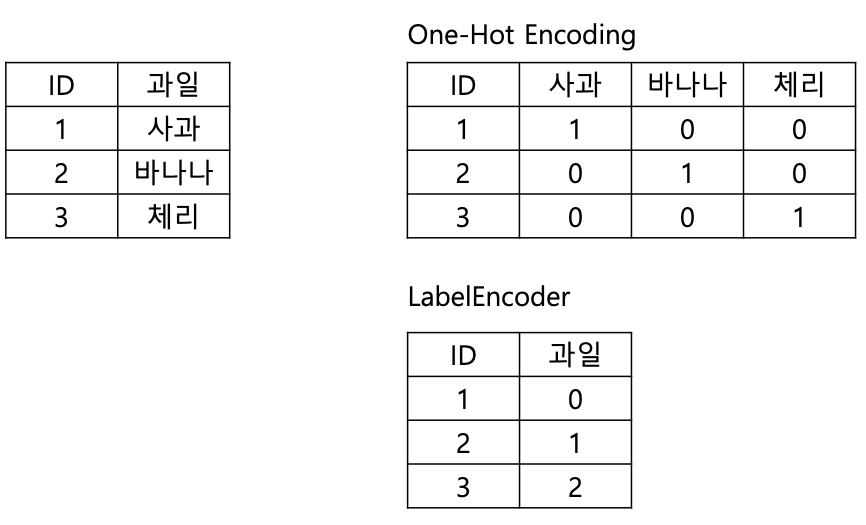

#### One-hot encoding

In [2]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
#         dummies = pd.get_dummies(csv.iloc[:, i])
#         dummies.columns = [j[0] + "_" + k for k in dummies.columns]
        data = pd.concat([data, csv.iloc[:, i]], axis = 1, sort = False)

data.loc[csv.y == "yes", "y"] = 1.0
data.loc[csv.y == "no", "y"] = -1.0
data.y = data.y.astype(float)

In [3]:
data_ts = data.copy()
data_ts.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,261.0,1.0,-1.0,0.0,unknown,-1.0
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,151.0,1.0,-1.0,0.0,unknown,-1.0
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,76.0,1.0,-1.0,0.0,unknown,-1.0
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,92.0,1.0,-1.0,0.0,unknown,-1.0
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,198.0,1.0,-1.0,0.0,unknown,-1.0


In [4]:
data_ts = data_ts.join(pd.get_dummies(data_ts['marital'], prefix='marital'))
data_ts[['marital', 'marital_married', 'marital_single', 'marital_divorced']].head()

,marital,marital_married,marital_single,marital_divorced
0,married,1,0,0
1,single,0,1,0
2,married,1,0,0
3,married,1,0,0
4,single,0,1,0


##### One-hot encoding을 사용한 데이터셋을 이용해 catboost 기반의 분류 진행

In [5]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
        dummies = pd.get_dummies(csv.iloc[:, i])
        dummies.columns = [j[0] + "_" + k for k in dummies.columns]
        data = pd.concat([data, dummies], axis = 1, sort = False)

data.loc[csv.y == "yes", "y"] = 1.0
data.loc[csv.y == "no", "y"] = -1.0
data.y = data.y.astype(float)

train_data, test_data = train_test_split(data, train_size = 0.7, random_state=42)

train_X = train_data.iloc[:, :-1].reset_index(drop = True) # train_X에 종속변수 제거
train_Y = train_data.iloc[:, -1].reset_index(drop = True) # train_Y에 종속변수 따로 저장

test_X = test_data.iloc[:, :-1].reset_index(drop = True) # test_X에 종속변수 제거
test_Y = test_data.iloc[:, -1].reset_index(drop = True) # test_Y에 종속변수 따로 저장

In [6]:
data

,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,contact_unknown,duration,campaign,pdays,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
0,58.0,0,0,0,0,1,0,0,0,0,...,1,261.0,1.0,-1.0,0.0,0,0,0,1,-1.0
1,44.0,0,0,0,0,0,0,0,0,0,...,1,151.0,1.0,-1.0,0.0,0,0,0,1,-1.0
2,33.0,0,0,1,0,0,0,0,0,0,...,1,76.0,1.0,-1.0,0.0,0,0,0,1,-1.0
3,47.0,0,1,0,0,0,0,0,0,0,...,1,92.0,1.0,-1.0,0.0,0,0,0,1,-1.0
4,33.0,0,0,0,0,0,0,0,0,0,...,1,198.0,1.0,-1.0,0.0,0,0,0,1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,0,0,0,0,0,0,0,0,0,...,0,977.0,3.0,-1.0,0.0,0,0,0,1,1.0
45207,71.0,0,0,0,0,0,1,0,0,0,...,0,456.0,2.0,-1.0,0.0,0,0,0,1,1.0
45208,72.0,0,0,0,0,0,1,0,0,0,...,0,1127.0,5.0,184.0,3.0,0,0,1,0,1.0
45209,57.0,0,1,0,0,0,0,0,0,0,...,0,508.0,4.0,-1.0,0.0,0,0,0,1,-1.0


In [ ]:
# CatBoost 모델(분류) package 불러오기
from catboost import CatBoostClassifier

# CatBoost 모델 생성하기
model = CatBoostClassifier()

# 모델에 데이터 fitting (학습)
model.fit(train_X, train_Y)

In [8]:
# 학습한 CatBoost 모델을 통해 테스트 데이터 예측
# pred 변수에 실제값 추가
pred = pd.DataFrame(test_Y)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
pred["pred"] = model.predict(test_X)

pred.head(10)

,y,pred
0,-1.0,-1.0
1,-1.0,-1.0
2,-1.0,-1.0
3,-1.0,-1.0
4,-1.0,-1.0
5,-1.0,-1.0
6,-1.0,-1.0
7,-1.0,-1.0
8,-1.0,-1.0
9,-1.0,-1.0


In [9]:
# Confusion Matrix 생성
tab = pd.crosstab(pred.y, pred.pred)

# 정확도 구하기
acc = (tab.iloc[0,0] + tab.iloc[1,1]) / len(test_Y)

print("Confusion Matrix")
print(tab)
print("   ")
print("Acc : ", acc)

Confusion Matrix
pred   -1.0   1.0
y                
-1.0  11571   395
 1.0    964   634
   
Acc :  0.8998083161309348


#### Label encoding

In [10]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
#         dummies = pd.get_dummies(csv.iloc[:, i])
#         dummies.columns = [j[0] + "_" + k for k in dummies.columns]
        data = pd.concat([data, csv.iloc[:, i]], axis = 1, sort = False)

data.loc[csv.y == "yes", "y"] = 1.0
data.loc[csv.y == "no", "y"] = -1.0
data.y = data.y.astype(float)

In [11]:
data_ts = data.copy()
data_ts.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,261.0,1.0,-1.0,0.0,unknown,-1.0
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,151.0,1.0,-1.0,0.0,unknown,-1.0
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,76.0,1.0,-1.0,0.0,unknown,-1.0
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,92.0,1.0,-1.0,0.0,unknown,-1.0
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,198.0,1.0,-1.0,0.0,unknown,-1.0


In [12]:
data_ts['job'].head()

0      management
1      technician
2    entrepreneur
3     blue-collar
4         unknown
Name: job, dtype: object

In [13]:
data_ts['job_label'] = pd.Categorical(data_ts['job']).codes
data_ts[['job', 'job_label']].head()

,job,job_label
0,management,4
1,technician,9
2,entrepreneur,2
3,blue-collar,1
4,unknown,11


##### Label encoding을 사용한 데이터셋을 이용해 catboost 기반의 분류 진행

In [14]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
        dummies = pd.Categorical(csv.iloc[:, i]).codes
        dummies = pd.Series(dummies, name=csv.iloc[:, i].name)
        data = pd.concat([data, dummies], axis = 1, sort = False)

data.loc[csv.y == "yes", "y"] = 1.0
data.loc[csv.y == "no", "y"] = -1.0
data.y = data.y.astype(float)

train_data, test_data = train_test_split(data, train_size = 0.7, random_state=42)

train_X = train_data.iloc[:, :-1].reset_index(drop = True) # train_X에 종속변수 제거
train_Y = train_data.iloc[:, -1].reset_index(drop = True) # train_Y에 종속변수 따로 저장

test_X = test_data.iloc[:, :-1].reset_index(drop = True) # test_X에 종속변수 제거
test_Y = test_data.iloc[:, -1].reset_index(drop = True) # test_Y에 종속변수 따로 저장

In [15]:
data

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58.0,4,1,2,0,2143.0,1,0,2,261.0,1.0,-1.0,0.0,3,-1.0
1,44.0,9,2,1,0,29.0,1,0,2,151.0,1.0,-1.0,0.0,3,-1.0
2,33.0,2,1,1,0,2.0,1,1,2,76.0,1.0,-1.0,0.0,3,-1.0
3,47.0,1,1,3,0,1506.0,1,0,2,92.0,1.0,-1.0,0.0,3,-1.0
4,33.0,11,2,3,0,1.0,0,0,2,198.0,1.0,-1.0,0.0,3,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,9,1,2,0,825.0,0,0,0,977.0,3.0,-1.0,0.0,3,1.0
45207,71.0,5,0,0,0,1729.0,0,0,0,456.0,2.0,-1.0,0.0,3,1.0
45208,72.0,5,1,1,0,5715.0,0,0,0,1127.0,5.0,184.0,3.0,2,1.0
45209,57.0,1,1,1,0,668.0,0,0,1,508.0,4.0,-1.0,0.0,3,-1.0


In [ ]:
# CatBoost 모델(분류) package 불러오기
from catboost import CatBoostClassifier

# CatBoost 모델 생성하기
model = CatBoostClassifier()

# 모델에 데이터 fitting (학습)
model.fit(train_X, train_Y)

In [17]:
# 학습한 CatBoost 모델을 통해 테스트 데이터 예측
# pred 변수에 실제값 추가
pred = pd.DataFrame(test_Y)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
pred["pred"] = model.predict(test_X)

pred.head(10)

,y,pred
0,-1.0,-1.0
1,-1.0,-1.0
2,-1.0,-1.0
3,-1.0,-1.0
4,-1.0,-1.0
5,-1.0,-1.0
6,-1.0,-1.0
7,-1.0,-1.0
8,-1.0,-1.0
9,-1.0,-1.0


In [18]:
# Confusion Matrix 생성
tab = pd.crosstab(pred.y, pred.pred)

# 정확도 구하기
acc = (tab.iloc[0,0] + tab.iloc[1,1]) / len(test_Y)

print("Confusion Matrix")
print(tab)
print("   ")
print("Acc : ", acc)

Confusion Matrix
pred   -1.0   1.0
y                
-1.0  11573   393
 1.0    976   622
   
Acc :  0.8990710704806841


### Target / Mean encoding (TS)

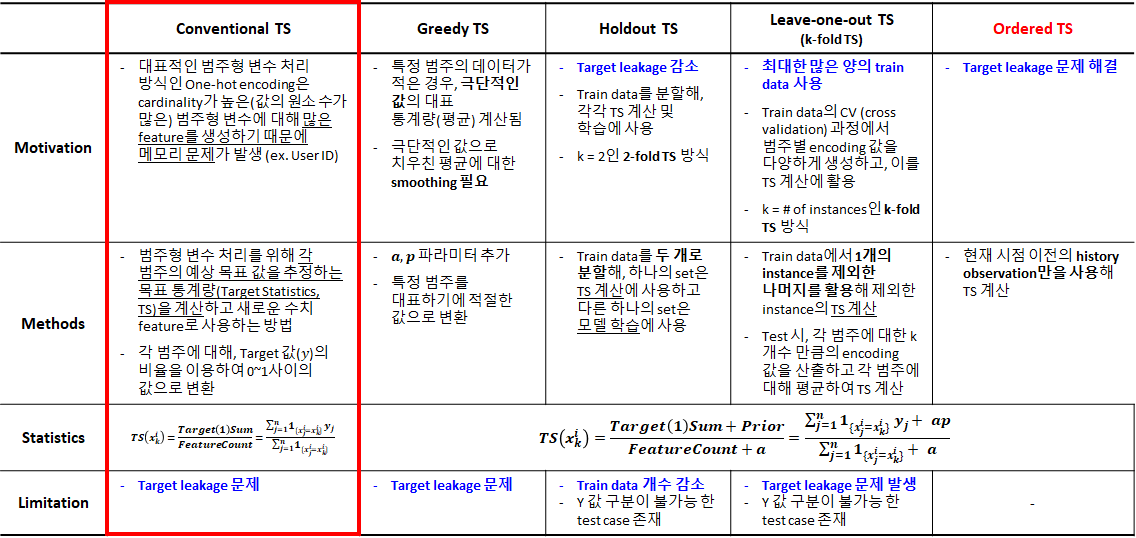

#### Conventional TS (Mean encoding)

In [19]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
#         dummies = pd.get_dummies(csv.iloc[:, i])
#         dummies.columns = [j[0] + "_" + k for k in dummies.columns]
        data = pd.concat([data, csv.iloc[:, i]], axis = 1, sort = False)

data.loc[csv.y == "yes", "y"] = 1.0
data.loc[csv.y == "no", "y"] = -1.0
data.y = data.y.astype(float)

In [20]:
data_ts = data.copy()
data_ts.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,261.0,1.0,-1.0,0.0,unknown,-1.0
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,151.0,1.0,-1.0,0.0,unknown,-1.0
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,76.0,1.0,-1.0,0.0,unknown,-1.0
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,92.0,1.0,-1.0,0.0,unknown,-1.0
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,198.0,1.0,-1.0,0.0,unknown,-1.0


In [21]:
# target 설정
target = 'y'

In [22]:
# target에 대한 job내 각 변수의 mean값을 계산
job_mean = data_ts.groupby('job')[target].mean()
job_mean

job
admin.          -0.755947
blue-collar     -0.854501
entrepreneur    -0.834566
housemaid       -0.824194
management      -0.724889
retired         -0.544170
self-employed   -0.763141
services        -0.822340
student         -0.426439
technician      -0.778860
unemployed      -0.689946
unknown         -0.763889
Name: y, dtype: float64

In [23]:
# 기존 변수에 encoded 된 값을 매핑
data_ts['job_mean'] = data_ts['job'].map(job_mean)
data_ts[['job', 'job_mean']].head()

,job,job_mean
0,management,-0.724889
1,technician,-0.778860
2,entrepreneur,-0.834566
3,blue-collar,-0.854501
4,unknown,-0.763889


##### Conventional TS을 사용한 데이터셋을 이용해 catboost 기반의 분류 진행

In [24]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

csv.loc[csv.y == "yes", "y"] = 1.0
csv.loc[csv.y == "no", "y"] = -1.0
csv.y = csv.y.astype(float)

# target 설정
target = 'y'

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
        temp_mean = csv.groupby(csv.iloc[:, i])[target].mean()
        dummy = csv[csv.iloc[:, i].name].map(temp_mean)
        data = pd.concat([data, dummy], axis = 1, sort = False)

data = pd.concat([data, csv['y']], axis=1)

In [25]:
data

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58.0,-0.724889,-0.797531,-0.699872,-0.764078,2143.0,-0.846001,-0.746885,-0.918587,261.0,1.0,-1.0,0.0,-0.816770,-1.0
1,44.0,-0.778860,-0.701016,-0.788811,-0.764078,29.0,-0.846001,-0.746885,-0.918587,151.0,1.0,-1.0,0.0,-0.816770,-1.0
2,33.0,-0.834566,-0.797531,-0.788811,-0.764078,2.0,-0.846001,-0.866372,-0.918587,76.0,1.0,-1.0,0.0,-0.816770,-1.0
3,47.0,-0.854501,-0.797531,-0.728595,-0.764078,1506.0,-0.846001,-0.746885,-0.918587,92.0,1.0,-1.0,0.0,-0.816770,-1.0
4,33.0,-0.763889,-0.701016,-0.728595,-0.764078,1.0,-0.665953,-0.746885,-0.918587,198.0,1.0,-1.0,0.0,-0.816770,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,-0.778860,-0.797531,-0.699872,-0.764078,825.0,-0.665953,-0.746885,-0.701622,977.0,3.0,-1.0,0.0,-0.816770,1.0
45207,71.0,-0.544170,-0.761091,-0.827470,-0.764078,1729.0,-0.665953,-0.746885,-0.701622,456.0,2.0,-1.0,0.0,-0.816770,1.0
45208,72.0,-0.544170,-0.797531,-0.788811,-0.764078,5715.0,-0.665953,-0.746885,-0.701622,1127.0,5.0,184.0,3.0,0.294507,1.0
45209,57.0,-0.854501,-0.797531,-0.788811,-0.764078,668.0,-0.665953,-0.746885,-0.731590,508.0,4.0,-1.0,0.0,-0.816770,-1.0


In [26]:
train_data, test_data = train_test_split(data, train_size = 0.7, random_state=42)

train_X = train_data.iloc[:, :-1].reset_index(drop = True) # train_X에 종속변수 제거
train_Y = train_data.iloc[:, -1].reset_index(drop = True) # train_Y에 종속변수 따로 저장

test_X = test_data.iloc[:, :-1].reset_index(drop = True) # test_X에 종속변수 제거
test_Y = test_data.iloc[:, -1].reset_index(drop = True) # test_Y에 종속변수 따로 저장

In [ ]:
# CatBoost 모델(분류) package 불러오기
from catboost import CatBoostClassifier

# CatBoost 모델 생성하기
model = CatBoostClassifier()

# 모델에 데이터 fitting (학습)
model.fit(train_X, train_Y)

In [28]:
# 학습한 CatBoost 모델을 통해 테스트 데이터 예측
# pred 변수에 실제값 추가
pred = pd.DataFrame(test_Y)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
pred["pred"] = model.predict(test_X)

pred.head(10)

,y,pred
0,-1.0,-1.0
1,-1.0,-1.0
2,-1.0,-1.0
3,-1.0,-1.0
4,-1.0,-1.0
5,-1.0,-1.0
6,-1.0,-1.0
7,-1.0,-1.0
8,-1.0,-1.0
9,-1.0,-1.0


In [29]:
# Confusion Matrix 생성
tab = pd.crosstab(pred.y, pred.pred)

# 정확도 구하기
acc = (tab.iloc[0,0] + tab.iloc[1,1]) / len(test_Y)

print("Confusion Matrix")
print(tab)
print("   ")
print("Acc : ", acc)

Confusion Matrix
pred   -1.0   1.0
y                
-1.0  11573   393
 1.0    974   624
   
Acc :  0.8992185196107343


#### Greedy TS (Smoothing TS)

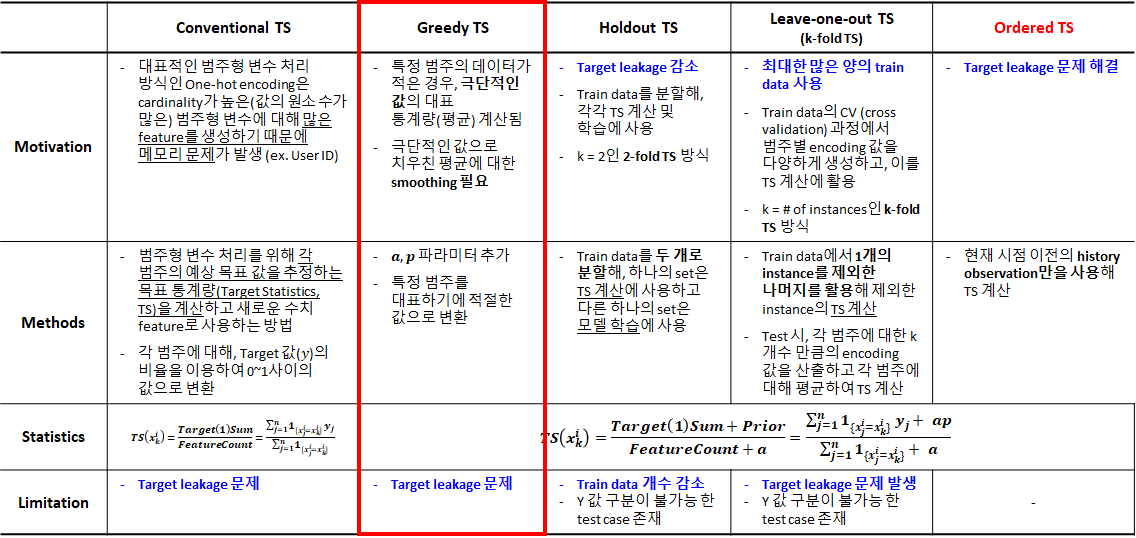

In [30]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
#         dummies = pd.get_dummies(csv.iloc[:, i])
#         dummies.columns = [j[0] + "_" + k for k in dummies.columns]
        data = pd.concat([data, csv.iloc[:, i]], axis = 1, sort = False)

data.loc[csv.y == "yes", "y"] = 1.0
data.loc[csv.y == "no", "y"] = -1.0
data.y = data.y.astype(float)

In [31]:
data_ts = data.copy()
data_ts.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,261.0,1.0,-1.0,0.0,unknown,-1.0
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,151.0,1.0,-1.0,0.0,unknown,-1.0
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,76.0,1.0,-1.0,0.0,unknown,-1.0
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,92.0,1.0,-1.0,0.0,unknown,-1.0
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,198.0,1.0,-1.0,0.0,unknown,-1.0


In [32]:
# target 설정
target = 'y'

In [33]:
# target에 대한 job내 각 변수의 mean값을 계산
job_mean = data_ts.groupby('job')[target].mean()
job_mean

job
admin.          -0.755947
blue-collar     -0.854501
entrepreneur    -0.834566
housemaid       -0.824194
management      -0.724889
retired         -0.544170
self-employed   -0.763141
services        -0.822340
student         -0.426439
technician      -0.778860
unemployed      -0.689946
unknown         -0.763889
Name: y, dtype: float64

In [34]:
# 기존 변수에 encoded 된 값을 매핑
data_ts['job_mean'] = data_ts['job'].map(job_mean)

In [35]:
data_ts['job_n_rows'] = data_ts['job'].map(data_ts.groupby('job').size())
global_mean = data_ts[target].mean()
alpha = 0.7 # smoothing을 위해 alpha 값 임의로 설정

def smoothing(n_rows, target_mean):
    return (target_mean*n_rows + global_mean*alpha) / (n_rows + alpha)

data_ts['job_mean_smoothing'] = data_ts.apply(lambda x:smoothing(x['job_n_rows'], x['job_mean']), axis=1)

In [36]:
data_ts[['job', 'job_mean', 'job_mean_smoothing']].head()

,job,job_mean,job_mean_smoothing
0,management,-0.724889,-0.724892
1,technician,-0.778860,-0.778859
2,entrepreneur,-0.834566,-0.834534
3,blue-collar,-0.854501,-0.854494
4,unknown,-0.763889,-0.763894


##### Greedy TS을 사용한 데이터셋을 이용해 catboost 기반의 분류 진행

In [37]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

csv.loc[csv.y == "yes", "y"] = 1.0
csv.loc[csv.y == "no", "y"] = -1.0
csv.y = csv.y.astype(float)

# target 설정
target = 'y'

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
        temp_mean = csv.groupby(csv.iloc[:, i])[target].mean()
        dummy = csv[csv.iloc[:, i].name].map(temp_mean)
        dummy_row = csv[csv.iloc[:, i].name].map(csv.groupby(csv.iloc[:, i].name).size())
        
        global_mean = csv[target].mean()
        alpha = 0.7 # smoothing을 위해 alpha 값 임의로 설정
        
        dummy_TS = (dummy*dummy_row + global_mean*alpha) / (dummy_row + alpha)
        
        data = pd.concat([data, dummy_TS], axis = 1, sort = False)

data = pd.concat([data, csv['y']], axis=1)

In [38]:
data

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58.0,-0.724892,-0.797530,-0.699876,-0.764078,2143.0,-0.845999,-0.746886,-0.918579,261.0,1.0,-1.0,0.0,-0.816769,-1.0
1,44.0,-0.778859,-0.701020,-0.788811,-0.764078,29.0,-0.845999,-0.746886,-0.918579,151.0,1.0,-1.0,0.0,-0.816769,-1.0
2,33.0,-0.834534,-0.797530,-0.788811,-0.764078,2.0,-0.845999,-0.866362,-0.918579,76.0,1.0,-1.0,0.0,-0.816769,-1.0
3,47.0,-0.854494,-0.797530,-0.728609,-0.764078,1506.0,-0.845999,-0.746886,-0.918579,92.0,1.0,-1.0,0.0,-0.816769,-1.0
4,33.0,-0.763894,-0.701020,-0.728609,-0.764078,1.0,-0.665956,-0.746886,-0.918579,198.0,1.0,-1.0,0.0,-0.816769,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,-0.778859,-0.797530,-0.699876,-0.764078,825.0,-0.665956,-0.746886,-0.701624,977.0,3.0,-1.0,0.0,-0.816769,1.0
45207,71.0,-0.544238,-0.761092,-0.827464,-0.764078,1729.0,-0.665956,-0.746886,-0.701624,456.0,2.0,-1.0,0.0,-0.816769,1.0
45208,72.0,-0.544238,-0.797530,-0.788811,-0.764078,5715.0,-0.665956,-0.746886,-0.701624,1127.0,5.0,184.0,3.0,0.294016,1.0
45209,57.0,-0.854494,-0.797530,-0.788811,-0.764078,668.0,-0.665956,-0.746886,-0.731598,508.0,4.0,-1.0,0.0,-0.816769,-1.0


In [39]:
train_data, test_data = train_test_split(data, train_size = 0.7, random_state=42)

train_X = train_data.iloc[:, :-1].reset_index(drop = True) # train_X에 종속변수 제거
train_Y = train_data.iloc[:, -1].reset_index(drop = True) # train_Y에 종속변수 따로 저장

test_X = test_data.iloc[:, :-1].reset_index(drop = True) # test_X에 종속변수 제거
test_Y = test_data.iloc[:, -1].reset_index(drop = True) # test_Y에 종속변수 따로 저장

In [ ]:
# CatBoost 모델(분류) package 불러오기
from catboost import CatBoostClassifier

# CatBoost 모델 생성하기
model = CatBoostClassifier()

# 모델에 데이터 fitting (학습)
model.fit(train_X, train_Y)

In [41]:
# 학습한 CatBoost 모델을 통해 테스트 데이터 예측
# pred 변수에 실제값 추가
pred = pd.DataFrame(test_Y)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
pred["pred"] = model.predict(test_X)

pred.head(10)

,y,pred
0,-1.0,-1.0
1,-1.0,-1.0
2,-1.0,-1.0
3,-1.0,-1.0
4,-1.0,-1.0
5,-1.0,-1.0
6,-1.0,-1.0
7,-1.0,-1.0
8,-1.0,-1.0
9,-1.0,-1.0


In [42]:
# Confusion Matrix 생성
tab = pd.crosstab(pred.y, pred.pred)

# 정확도 구하기
acc = (tab.iloc[0,0] + tab.iloc[1,1]) / len(test_Y)

print("Confusion Matrix")
print(tab)
print("   ")
print("Acc : ", acc)

Confusion Matrix
pred   -1.0   1.0
y                
-1.0  11573   393
 1.0    974   624
   
Acc :  0.8992185196107343


#### Leave-one-out TS (k-fold TS)

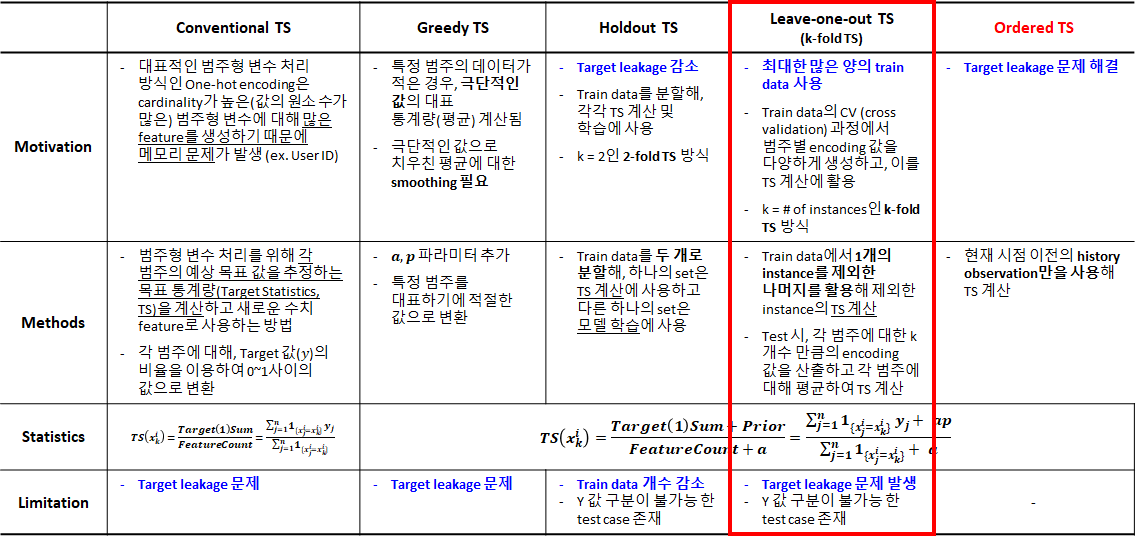

In [43]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
#         dummies = pd.get_dummies(csv.iloc[:, i])
#         dummies.columns = [j[0] + "_" + k for k in dummies.columns]
        data = pd.concat([data, csv.iloc[:, i]], axis = 1, sort = False)

data.loc[csv.y == "yes", "y"] = 1.0
data.loc[csv.y == "no", "y"] = -1.0
data.y = data.y.astype(float)

data_ts = data.copy()
data_ts.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,261.0,1.0,-1.0,0.0,unknown,-1.0
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,151.0,1.0,-1.0,0.0,unknown,-1.0
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,76.0,1.0,-1.0,0.0,unknown,-1.0
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,92.0,1.0,-1.0,0.0,unknown,-1.0
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,198.0,1.0,-1.0,0.0,unknown,-1.0


In [44]:
# encoding에는 train set만 사용됨
train, test = train_test_split(data_ts, test_size=0.2, random_state=42, shuffle=True)

# train -> train_new 로 될 예정이므로, 미리 데이터프레임 생성
train_new = train.copy()
train_new[:] = np.nan
train_new['job_mean'] = np.nan

In [45]:
# k-fold 구분을 위해 package 불러오기
from sklearn.model_selection import StratifiedKFold

# K-fold 만들기 (k=5)
X_train = train.drop(target, axis=1)
Y_train = train[target]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold iteration
for tr_idx, val_idx in skf.split(X_train, Y_train):
    X_train, X_val = train.iloc[tr_idx], train.iloc[val_idx]

    # train set에서 구한 mean encoded 값을 validation set에 매핑
    means = X_val['job'].map(X_train.groupby('job')[target].mean())
    X_val['job_mean'] = means
    train_new.iloc[val_idx] = X_val

# 폴드에 속하지못한 데이터들은 글로벌 평균으로 채우기
global_mean = train[target].mean()
print('global mean: ', global_mean)

train_new['job'] = train_new['job'].fillna(global_mean)

global mean:  -0.7678610926786109


In [46]:
train_new[['job', 'job_mean']].head()

,job,job_mean
3344,blue-collar,-0.858038
17965,technician,-0.782413
18299,admin.,-0.752404
10221,management,-0.730315
32192,blue-collar,-0.859015


##### Leave-one-out TS을 사용한 데이터셋을 이용해 catboost 기반의 분류 진행

In [47]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

csv.loc[csv.y == "yes", "y"] = 1.0
csv.loc[csv.y == "no", "y"] = -1.0
csv.y = csv.y.astype(float)

# target 설정
target = 'y'

# encoding에는 train set만 사용됨
train, test = train_test_split(csv, test_size=0.2, random_state=42, shuffle=True)

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
        # train -> train_new 로 될 예정이므로, 미리 데이터프레임 생성
        train_new = train.copy()
        train_new[:] = np.nan
        train_new[csv.iloc[:, i].name+'_mean'] = np.nan

        # K-fold 만들기 (k=5)
        X_train = train.drop(target, axis=1)
        Y_train = train[target]
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # 각 fold iteration
        for tr_idx, val_idx in skf.split(X_train, Y_train):
            X_train, X_val = train.iloc[tr_idx], train.iloc[val_idx]

            # train set에서 구한 mean encoded 값을 validation set에 매핑
            means = X_val[csv.iloc[:, i].name].map(X_train.groupby(csv.iloc[:, i].name)[target].mean())
            X_val[csv.iloc[:, i].name+'_mean'] = means
            train_new.iloc[val_idx] = X_val

        # 폴드에 속하지못한 데이터들은 글로벌 평균으로 채우기
        global_mean = train[target].mean()
        train_new[csv.iloc[:, i].name] = train_new[csv.iloc[:, i].name].fillna(global_mean)
                
        data = pd.concat([data, train_new[csv.iloc[:, i].name+'_mean']], axis = 1, sort = False)

print('global mean: ', global_mean)
data = pd.concat([data, csv['y']], axis=1)

global mean:  -0.7678610926786109


In [48]:
data.dropna(inplace=True)
data = data.reset_index(drop=True)
data.head()

,age,job_mean,marital_mean,education_mean,default_mean,balance,housing_mean,loan_mean,contact_mean,duration,campaign,pdays,previous,poutcome_mean,y
0,58.0,-0.726347,-0.800814,-0.695895,-0.765480,2143.0,-0.848464,-0.749517,-0.924350,261.0,1.0,-1.0,0.0,-0.818120,-1.0
1,33.0,-0.841102,-0.800814,-0.789845,-0.765480,2.0,-0.848464,-0.865129,-0.924350,76.0,1.0,-1.0,0.0,-0.818120,-1.0
2,47.0,-0.852195,-0.797785,-0.738115,-0.766032,1506.0,-0.848888,-0.748133,-0.920811,92.0,1.0,-1.0,0.0,-0.818174,-1.0
3,35.0,-0.727620,-0.798685,-0.703765,-0.766028,231.0,-0.848211,-0.749763,-0.922209,139.0,1.0,-1.0,0.0,-0.819081,-1.0
4,28.0,-0.727651,-0.707257,-0.703108,-0.765688,447.0,-0.847387,-0.866468,-0.921990,217.0,1.0,-1.0,0.0,-0.820443,-1.0


In [49]:
train_data, test_data = train_test_split(data, train_size = 0.7, random_state=42)

train_X = train_data.iloc[:, :-1].reset_index(drop = True) # train_X에 종속변수 제거
train_Y = train_data.iloc[:, -1].reset_index(drop = True) # train_Y에 종속변수 따로 저장

test_X = test_data.iloc[:, :-1].reset_index(drop = True) # test_X에 종속변수 제거
test_Y = test_data.iloc[:, -1].reset_index(drop = True) # test_Y에 종속변수 따로 저장

In [ ]:
# CatBoost 모델(분류) package 불러오기
from catboost import CatBoostClassifier

# CatBoost 모델 생성하기
model = CatBoostClassifier()

# 모델에 데이터 fitting (학습)
model.fit(train_X, train_Y)

In [51]:
# 학습한 CatBoost 모델을 통해 테스트 데이터 예측
# pred 변수에 실제값 추가
pred = pd.DataFrame(test_Y)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
pred["pred"] = model.predict(test_X)

pred.head(10)

,y,pred
0,-1.0,-1.0
1,-1.0,-1.0
2,-1.0,-1.0
3,-1.0,-1.0
4,1.0,-1.0
5,-1.0,-1.0
6,-1.0,-1.0
7,-1.0,-1.0
8,-1.0,-1.0
9,-1.0,-1.0


In [52]:
# Confusion Matrix 생성
tab = pd.crosstab(pred.y, pred.pred)

# 정확도 구하기
acc = (tab.iloc[0,0] + tab.iloc[1,1]) / len(test_Y)

print("Confusion Matrix")
print(tab)
print("   ")
print("Acc : ", acc)

Confusion Matrix
pred  -1.0   1.0
y               
-1.0  9305   259
 1.0   780   507
   
Acc :  0.9042484563634688


#### Ordered TS

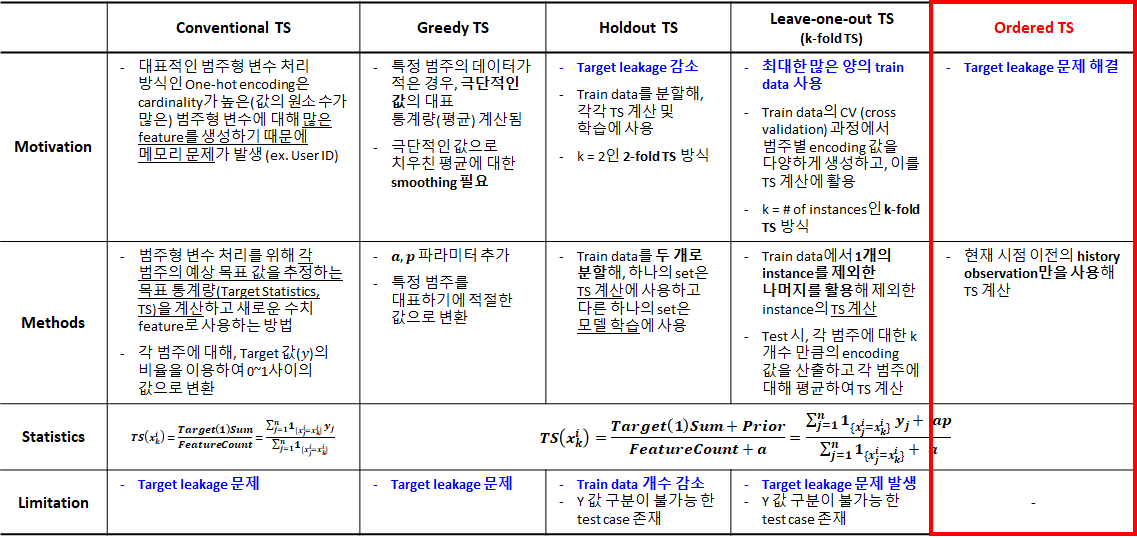

In [53]:
csv = pd.read_csv("Data_bank-full.csv", encoding = "UTF-8-sig", sep = ";")
csv = csv.drop(['day', 'month'], axis=1)

data = pd.DataFrame()
for i, j in enumerate(csv.iloc[:, : -1].dtypes.items()):
    if j[1] == "int64":
        data = pd.concat([data, csv.iloc[:, i].astype(float)], axis = 1, sort = False)
    else:
#         dummies = pd.get_dummies(csv.iloc[:, i])
#         dummies.columns = [j[0] + "_" + k for k in dummies.columns]
        data = pd.concat([data, csv.iloc[:, i]], axis = 1, sort = False)

data.loc[csv.y == "yes", "y"] = 1.0
data.loc[csv.y == "no", "y"] = -1.0
data.y = data.y.astype(float)

In [54]:
data_ts = data.copy()
data_ts.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,261.0,1.0,-1.0,0.0,unknown,-1.0
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,151.0,1.0,-1.0,0.0,unknown,-1.0
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,76.0,1.0,-1.0,0.0,unknown,-1.0
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,92.0,1.0,-1.0,0.0,unknown,-1.0
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,198.0,1.0,-1.0,0.0,unknown,-1.0


In [55]:
# target 설정
target = data_ts['y']
train = data_ts.drop('y', axis = 1)

In [56]:
# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder()
  
# Fit encoder and transform the features
cbe_encoder.fit(train, target)
train_cbe = cbe_encoder.transform(train)

In [57]:
train_cbe = pd.concat([train_cbe, data['y']], axis=1)
train_cbe

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58.0,-0.724893,-0.797530,-0.699877,-0.764078,2143.0,-0.845998,-0.746886,-0.918575,261.0,1.0,-1.0,0.0,-0.816769,-1.0
1,44.0,-0.778858,-0.701022,-0.788810,-0.764078,29.0,-0.845998,-0.746886,-0.918575,151.0,1.0,-1.0,0.0,-0.816769,-1.0
2,33.0,-0.834520,-0.797530,-0.788810,-0.764078,2.0,-0.845998,-0.866358,-0.918575,76.0,1.0,-1.0,0.0,-0.816769,-1.0
3,47.0,-0.854492,-0.797530,-0.728615,-0.764078,1506.0,-0.845998,-0.746886,-0.918575,92.0,1.0,-1.0,0.0,-0.816769,-1.0
4,33.0,-0.763896,-0.701022,-0.728615,-0.764078,1.0,-0.665958,-0.746886,-0.918575,198.0,1.0,-1.0,0.0,-0.816769,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,-0.778858,-0.797530,-0.699877,-0.764078,825.0,-0.665958,-0.746886,-0.701624,977.0,3.0,-1.0,0.0,-0.816769,1.0
45207,71.0,-0.544268,-0.761092,-0.827461,-0.764078,1729.0,-0.665958,-0.746886,-0.701624,456.0,2.0,-1.0,0.0,-0.816769,1.0
45208,72.0,-0.544268,-0.797530,-0.788810,-0.764078,5715.0,-0.665958,-0.746886,-0.701624,1127.0,5.0,184.0,3.0,0.293806,1.0
45209,57.0,-0.854492,-0.797530,-0.788810,-0.764078,668.0,-0.665958,-0.746886,-0.731602,508.0,4.0,-1.0,0.0,-0.816769,-1.0


##### Ordered TS를 사용한 데이터셋을 이용해 catboost 기반의 분류 진행

In [58]:
train_data, test_data = train_test_split(train_cbe, train_size = 0.7, random_state=42)

train_X = train_data.iloc[:, :-1].reset_index(drop = True) # train_X에 종속변수 제거
train_Y = train_data.iloc[:, -1].reset_index(drop = True) # train_Y에 종속변수 따로 저장

test_X = test_data.iloc[:, :-1].reset_index(drop = True) # test_X에 종속변수 제거
test_Y = test_data.iloc[:, -1].reset_index(drop = True) # test_Y에 종속변수 따로 저장

In [ ]:
# CatBoost 모델(분류) package 불러오기
from catboost import CatBoostClassifier

# CatBoost 모델 생성하기
model = CatBoostClassifier()

# 모델에 데이터 fitting (학습)
model.fit(train_X, train_Y)

In [60]:
# 학습한 CatBoost 모델을 통해 테스트 데이터 예측
# pred 변수에 실제값 추가
pred = pd.DataFrame(test_Y)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
pred["pred"] = model.predict(test_X)

pred.head(10)

,y,pred
0,-1.0,-1.0
1,-1.0,-1.0
2,-1.0,-1.0
3,-1.0,-1.0
4,-1.0,-1.0
5,-1.0,-1.0
6,-1.0,-1.0
7,-1.0,1.0
8,-1.0,1.0
9,-1.0,-1.0


In [61]:
# Confusion Matrix 생성
tab = pd.crosstab(pred.y, pred.pred)

# 정확도 구하기
acc = (tab.iloc[0,0] + tab.iloc[1,1]) / len(test_Y)

print("Confusion Matrix")
print(tab)
print("   ")
print("Acc : ", acc)

Confusion Matrix
pred   -1.0   1.0
y                
-1.0  11639   362
 1.0    907   656
   
Acc :  0.9064435269831908


- 실험 결과, 2가지의 전통적 방법과 4가지의 TS를 구성하는 방법으로, 총 6가지 범주형 변수 처리 방법을 진행했습니다.

    - 각 case 별로 나온 분류 성능의 결과는 다음과 같다.
        - One-hot encoding:  0.8998083161309348, 89.98%
        - Label encoding  :  0.8990710704806841, 89.91%
        - Conventional TS :  0.8992185196107343, 89.92%
        - Greedy TS       :  0.8992185196107343, 89.92%
        - Leave-one-out TS:  0.9042484563634688, 90.42%
        - Ordered TS      :  0.9064435269831908, 90.64%

- 정확도 성능면에서, 크게 차이를 보이지는 않지만, 패턴을 보면 기존 범주 인코딩부터 개발된 TS 처리 방법으로 진행될 수록 결과 값이 좋아지는 모습을 확인할 수 있다.
- 이는, Ordered TS가 범주형 변수의 처리에 있어서 좋은 방법임을 얘기해주는 증거가 될 것 이라고 생각한다.
- 따라서 알려진 것처럼 conventional categorical encoding의 2가지 방법과, target leakage가 발생되는 3가지 TS 방법에 대하여, Ordered TS를 사용하는 Catboost가 범주형 데이터가 포함된 분류 문제를 잘 다룬다고 생각하는 계기가 되었다.

# Referrence

https://catboost.ai/en/docs/concepts/parameter-tuning

# EOD